In [11]:
import requests
import pandas as pd

url = "https://cea.nic.in/api/psp_energy.php"
response = requests.get(url)

if response.status_code == 200:
    data = response.json()  # Parse JSON response
else:
    raise Exception(f"Failed to fetch data: {response.status_code}")

# Step 2: Extract data for Delhi
# Combine data from all financial years (keys of the JSON)
delhi_data = []
for year, records in data.items():
    for record in records:
        if record["State"].strip().lower() == "delhi":
            delhi_data.append(record)

# Step 3: Convert to DataFrame
delhi_df = pd.DataFrame(delhi_data)

# Step 4: Clean and process the DataFrame
# Convert numeric columns from strings to floats
delhi_df["energy_requirement"] = pd.to_numeric(delhi_df["energy_requirement"], errors='coerce')
delhi_df["energy_availability"] = pd.to_numeric(delhi_df["energy_availability"], errors='coerce')

# Optional: Remove unwanted columns (e.g., "ID" or others)
delhi_df = delhi_df.drop(columns=["ID"], errors="ignore")


# Save to a CSV file
delhi_df.to_csv("delhi_energy_data.csv", index=False)


In [12]:
delhi_df=pd.read_csv("delhi_energy_data.csv")
print(delhi_df.tail())

       Month   State  energy_requirement  energy_availability         fy
60  Feb-2024   Delhi         2187.056741          2186.382543  2023-2024
61  Mar-2024   Delhi         2216.859549          2216.642283  2023-2024
62  Apr-2024   Delhi         2859.951076          2859.635923  2024-2025
63  May-2024   Delhi         4207.625879          4204.963102  2024-2025
64  Jun-2024   Delhi         4545.508396          4540.582260  2024-2025


In [13]:
delhi_df=delhi_df.set_index('fy')
delhi_df.head()

,Month,State,energy_requirement,energy_availability
fy,,,,
2019-2020,Jan-2020,Delhi,2290.02,2290.02
2019-2020,Jan-2020,Delhi,2290.02,2290.02
2019-2020,Jan-2020,Delhi,2290.02,2290.02
2019-2020,Feb-2020,Delhi,1904.80,1904.53
2019-2020,Feb-2020,Delhi,1904.80,1904.53


In [14]:
print(delhi_df.describe())

       energy_requirement  energy_availability
count           65.000000            65.000000
mean          2531.382118          2530.622904
std            937.941350           937.248663
min            183.000000           183.000000
25%           2090.545000          2090.149000
50%           2290.020000          2290.020000
75%           3201.586000          3200.931000
max           4545.508396          4540.582260


In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import tensorflow as tf

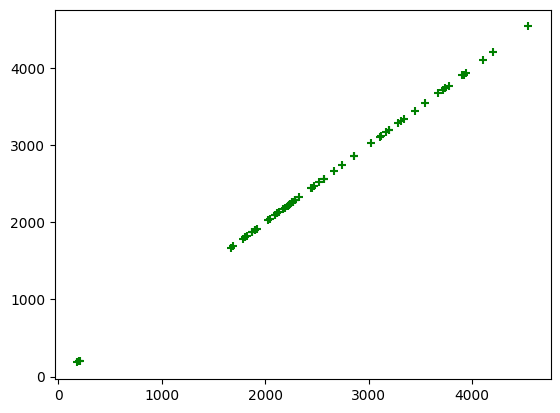

In [16]:

plt.scatter(delhi_df['energy_requirement'],delhi_df['energy_availability'],marker="+",color='green')

plt.show()

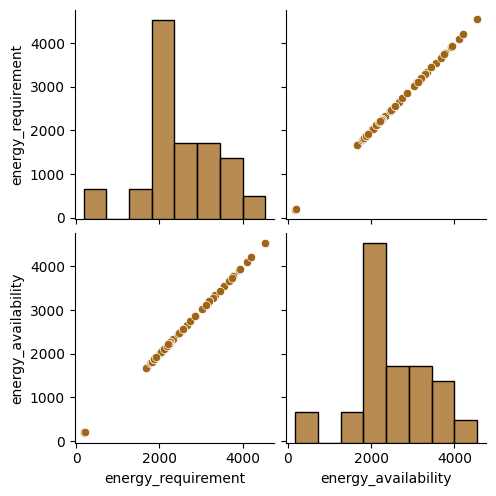

In [17]:

sns.set_palette('BrBG')
sns.pairplot(delhi_df)

Mean Squared Error: 1294252.06
Mean Absolute Error: 630.94


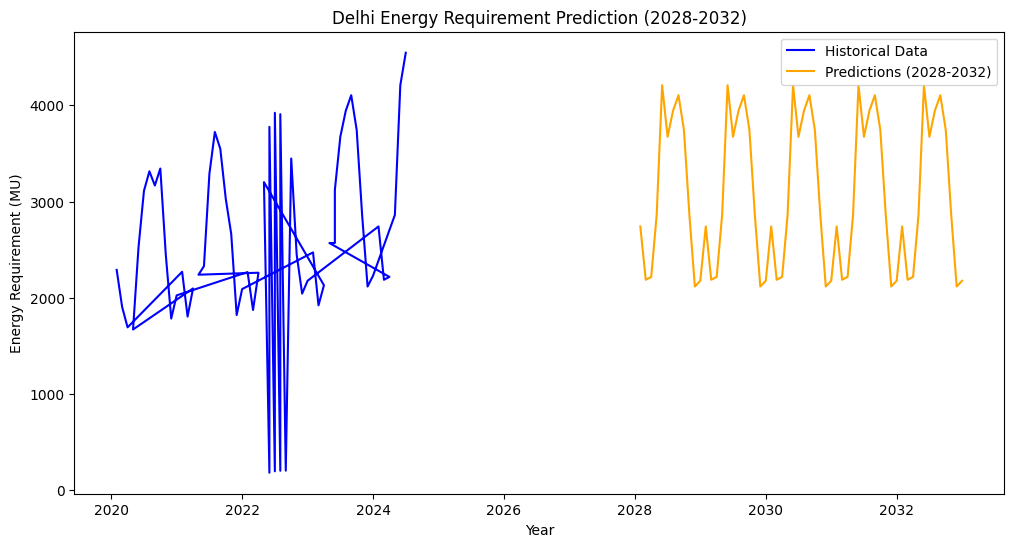

In [26]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

delhi_df['Year'] = pd.to_datetime(delhi_df['Month'], format='%b-%Y').dt.year
delhi_df['Month_num'] = pd.to_datetime(delhi_df['Month'], format='%b-%Y').dt.month

# Features (Month and Year) and Target (energy_requirement)
X = delhi_df[['Year', 'Month_num']]
y = delhi_df['energy_requirement']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Decision Tree Regressor
model = DecisionTreeRegressor(random_state=42)
model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Squared Error: {mse:.2f}")
print(f"Mean Absolute Error: {mae:.2f}")

# Predict future requirements for 2028-2032
future_years = range(2028, 2033)
future_months = range(1, 13)
future_data = pd.DataFrame([(year, month) for year in future_years for month in future_months],
                           columns=['Year', 'Month_num'])

# Predict using the trained model
future_predictions = model.predict(future_data)

# Create a DataFrame for future predictions
future_df = pd.DataFrame({
    'Year': future_data['Year'],
    'Month': future_data['Month_num'],
    'Predicted_energy_requirement': future_predictions
})

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(delhi_df['Year'] + delhi_df['Month_num'] / 12.0, delhi_df['energy_requirement'], label="Historical Data", color='blue')
plt.plot(future_df['Year'] + future_df['Month'] / 12.0, future_df['Predicted_energy_requirement'], label="Predictions (2028-2032)", color='orange')
plt.title("Delhi Energy Requirement Prediction (2028-2032)")
plt.xlabel("Year")
plt.ylabel("Energy Requirement (MU)")
plt.legend()
plt.show()